#  <font color='red'>Table of Contents</font>

[5. Final Data Preparation](#section6)<br>
[6. Evaluation Metrics](#section6)<br>
[7. Ridge Model](#section7)<br>
[8. LGBM Model](#section8)<br>
[9. Regression Ensemble Model](#section9)<br>

In [2]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV

# DL Libs..

CWD is  C:\Users\demitra\Downloads\mercari


C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  <a id = 'section5'> <font color='red'>  5. Final Data Preparation  </font> </a>

In [3]:
file = open('train_bow_name', 'rb')
train_bow_name = pickle.load(file)
file.close()

file = open('train_bow_desc', 'rb')
train_bow_desc = pickle.load(file)
file.close()

file = open('train_brand', 'rb')
train_brand = pickle.load(file)
file.close()

file = open('train_category', 'rb')
train_category = pickle.load(file)
file.close()

file = open('train_dummies', 'rb')
train_dummies = pickle.load(file)
file.close()

file = open('y_train', 'rb')
y_train = pickle.load(file)
file.close()

In [4]:
file = open('test_bow_name', 'rb')
test_bow_name = pickle.load(file)
file.close()

file = open('test_bow_desc', 'rb')
test_bow_desc = pickle.load(file)
file.close()

file = open('test_brand', 'rb')
test_brand = pickle.load(file)
file.close()

file = open('test_category', 'rb')
test_category = pickle.load(file)
file.close()

file = open('test_dummies', 'rb')
test_dummies = pickle.load(file)
file.close()

file = open('y_test', 'rb')
y_test = pickle.load(file)
file.close()

In [5]:
# ref - https://stackoverflow.com/questions/50250432/python-lightgbm-text-classicication-with-tfidf

X_train = scipy.sparse.hstack((train_bow_name,train_bow_desc,
                               train_brand,train_category,train_dummies
                              )).tocsr().astype('float32')

X_test = scipy.sparse.hstack((test_bow_name,test_bow_desc,
                               test_brand,test_category,test_dummies
                              )).tocsr().astype('float32')

print("X_train Shape is ",X_train.shape)
print("X_test Shape is ",X_test.shape)
print("y_train Shape is ",y_train.shape)
print("y_test Shape is ",y_test.shape)

X_train Shape is  (1111222, 137166)
X_test Shape is  (370634, 137166)
y_train Shape is  (1111222,)
y_test Shape is  (370634,)


#  <a id = 'section6'> <font color='red'>  6. Evaluation Metrics  </font> </a>

In [6]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [7]:
def rmsle_lgb(labels, preds):
    return 'rmsle', rmsle_score(preds, labels), False

In [8]:
def rmse_score(y,y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

#  <a id = 'section7'> <font color='red'>  7. Ridge Model  </font> </a>

### <font color='red'> 7.1 Using Existing Hyperparameters </font>

In [9]:
ridge_model = Ridge(solver = "lsqr", fit_intercept=False)
ridge_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [10]:
preds = np.expm1(ridge_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')
print('Train RMSE = ',rmse_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSE = ',rmse_score(np.expm1(y_test) , preds))

Train RMSLE =  0.4356421818101252
Test RMSLE =  0.4743779017961746 

Train RMSE =  32.783025933275546
Test RMSE =  35.72134789675083


### <font color='red'> 7.2 Tune Hyperparameters </font>

In [12]:
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
              'fit_intercept' : [False],
              'solver' : ['lsqr']}

gs_ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 100,
                        return_train_score = True,
                        n_jobs = -2)
gs_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
Memmapping (shape=(44325367,), dtype=int32) to new file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-6cc1f32591dd4847b562f56c3f7880e1.pkl
Memmapping (shape=(1111223,), dtype=int32) to new file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-f69a4deab326481a911f6413a28e2920.pkl
Memmapping (shape=(44325367,), dtype=int64) to new file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-4cfc472a2c3446f39d41c1906ba538e4.pkl
Memmapping (shape=(1111222,), dtype=float64) to new file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-f46eab5224834eb689f3a3e4ae072c94.pkl
Memmapping (shape=(740814,), dtype=int32) to new file C:\Users\demitra\AppData\Local\Temp\joblib_mem

Memmapping (shape=(44325367,), dtype=int32) to old file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-6cc1f32591dd4847b562f56c3f7880e1.pkl
Memmapping (shape=(1111223,), dtype=int32) to old file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-f69a4deab326481a911f6413a28e2920.pkl
Memmapping (shape=(44325367,), dtype=int64) to old file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-4cfc472a2c3446f39d41c1906ba538e4.pkl
Memmapping (shape=(1111222,), dtype=float64) to old file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-f46eab5224834eb689f3a3e4ae072c94.pkl
Memmapping (shape=(740815,), dtype=int32) to old file C:\Users\demitra\AppData\Local\Temp\joblib_memmapping_folder_11004_1841699450\11004-2237703027904-54ac2472502d4a24a4e17a96c197f12a.pkl
Memmapping (shape=(370407,), dtype=int32) to ol

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:  4.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000],
                         'fit_intercept': [False], 'solver': ['lsqr']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=100)

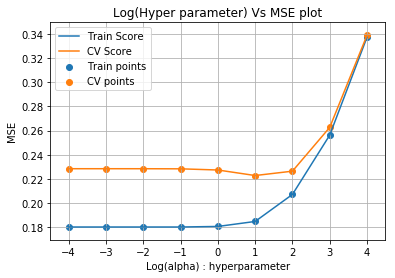

Best Estimator  Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)


In [16]:
results = pd.DataFrame.from_dict(gs_ridge.cv_results_)
results = results.sort_values(['param_alpha'])

train_score = results['mean_train_score']*-1
cv_score = results['mean_test_score'] *-1
hyp =  results['param_alpha']

plt.plot(np.log10(list(hyp.values)), train_score, label='Train Score')
plt.plot(np.log10(list(hyp.values)), cv_score, label='CV Score')

plt.scatter(np.log10(list(hyp.values)), train_score, label='Train points')
plt.scatter(np.log10(list(hyp.values)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Log(alpha) : hyperparameter")
plt.ylabel("Score")
plt.title("Log(Hyper parameter) Vs Score plot")
plt.grid()
plt.show()

print("Best Estimator ",gs_ridge.best_estimator_)
#results

In [13]:
ridge_model = Ridge(solver = "lsqr", fit_intercept=False,alpha = 10)
ridge_model.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [35]:
#file = open('ridge_model', 'wb')
#pickle.dump(ridge_model, file)
#file.close()

In [18]:
preds = np.expm1(ridge_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')
print('Train RMSE = ',rmse_score(np.expm1(y_train) , np.expm1(ridge_model.predict(X_train))))
print('Test RMSE = ',rmse_score(np.expm1(y_test) , preds))

Train RMSLE =  0.43729974362744295
Test RMSLE =  0.47257242846526254 

Train RMSE =  33.21153417854374
Test RMSE =  33.03911540643673


##### Summary - Only slight improvement observed from 0.474 to 0.472 in Test RMSLE after hyperparameter tuning

#  <a id = 'section8'> <font color='red'>  8. LGBM Model  </font> </a>

### <font color='red'> 8.1 Using Existing Hyperparameters </font>

In [40]:
lgbm_params = {'n_estimators': 900, 'learning_rate': 0.15, 'max_depth': 5,
               'num_leaves': 31, 'subsample': 0.9, 'colsample_bytree': 0.8,
               'min_child_samples': 50, 'n_jobs': -2}


lgbm_model = lgb.LGBMRegressor(**lgbm_params)
#lgbm_model.fit(X_train,y_train)

lgbm_model.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric=rmsle_lgb,
         early_stopping_rounds=None,
         verbose=True)

[1]	valid_0's l2: 0.530642	valid_0's rmsle: 0.18261
[2]	valid_0's l2: 0.51104	valid_0's rmsle: 0.179147
[3]	valid_0's l2: 0.494551	valid_0's rmsle: 0.176199
[4]	valid_0's l2: 0.481369	valid_0's rmsle: 0.173981
[5]	valid_0's l2: 0.469988	valid_0's rmsle: 0.17189
[6]	valid_0's l2: 0.460755	valid_0's rmsle: 0.170188
[7]	valid_0's l2: 0.453371	valid_0's rmsle: 0.168824
[8]	valid_0's l2: 0.446322	valid_0's rmsle: 0.167512
[9]	valid_0's l2: 0.440275	valid_0's rmsle: 0.166435
[10]	valid_0's l2: 0.435516	valid_0's rmsle: 0.165652
[11]	valid_0's l2: 0.429873	valid_0's rmsle: 0.16464
[12]	valid_0's l2: 0.425332	valid_0's rmsle: 0.163854
[13]	valid_0's l2: 0.42206	valid_0's rmsle: 0.163323
[14]	valid_0's l2: 0.416966	valid_0's rmsle: 0.162325
[15]	valid_0's l2: 0.414173	valid_0's rmsle: 0.161865
[16]	valid_0's l2: 0.411219	valid_0's rmsle: 0.161309
[17]	valid_0's l2: 0.408214	valid_0's rmsle: 0.160744
[18]	valid_0's l2: 0.405233	valid_0's rmsle: 0.16017
[19]	valid_0's l2: 0.403331	valid_0's rmsle

[301]	valid_0's l2: 0.286841	valid_0's rmsle: 0.13625
[302]	valid_0's l2: 0.286687	valid_0's rmsle: 0.136216
[303]	valid_0's l2: 0.286585	valid_0's rmsle: 0.136193
[304]	valid_0's l2: 0.286507	valid_0's rmsle: 0.136177
[305]	valid_0's l2: 0.286407	valid_0's rmsle: 0.136154
[306]	valid_0's l2: 0.2863	valid_0's rmsle: 0.136133
[307]	valid_0's l2: 0.286201	valid_0's rmsle: 0.136111
[308]	valid_0's l2: 0.286093	valid_0's rmsle: 0.136082
[309]	valid_0's l2: 0.285978	valid_0's rmsle: 0.136053
[310]	valid_0's l2: 0.28588	valid_0's rmsle: 0.136028
[311]	valid_0's l2: 0.285777	valid_0's rmsle: 0.136006
[312]	valid_0's l2: 0.285671	valid_0's rmsle: 0.135984
[313]	valid_0's l2: 0.285582	valid_0's rmsle: 0.135964
[314]	valid_0's l2: 0.285487	valid_0's rmsle: 0.135941
[315]	valid_0's l2: 0.285401	valid_0's rmsle: 0.135924
[316]	valid_0's l2: 0.285237	valid_0's rmsle: 0.135892
[317]	valid_0's l2: 0.285112	valid_0's rmsle: 0.135856
[318]	valid_0's l2: 0.284975	valid_0's rmsle: 0.135823
[319]	valid_0'

[599]	valid_0's l2: 0.264228	valid_0's rmsle: 0.13104
[600]	valid_0's l2: 0.264189	valid_0's rmsle: 0.13103
[601]	valid_0's l2: 0.264147	valid_0's rmsle: 0.131022
[602]	valid_0's l2: 0.264083	valid_0's rmsle: 0.131005
[603]	valid_0's l2: 0.264045	valid_0's rmsle: 0.130996
[604]	valid_0's l2: 0.264002	valid_0's rmsle: 0.130985
[605]	valid_0's l2: 0.263967	valid_0's rmsle: 0.130978
[606]	valid_0's l2: 0.263903	valid_0's rmsle: 0.130965
[607]	valid_0's l2: 0.263866	valid_0's rmsle: 0.130956
[608]	valid_0's l2: 0.26382	valid_0's rmsle: 0.130946
[609]	valid_0's l2: 0.263757	valid_0's rmsle: 0.130931
[610]	valid_0's l2: 0.263727	valid_0's rmsle: 0.130924
[611]	valid_0's l2: 0.263675	valid_0's rmsle: 0.130909
[612]	valid_0's l2: 0.26362	valid_0's rmsle: 0.130897
[613]	valid_0's l2: 0.263585	valid_0's rmsle: 0.13089
[614]	valid_0's l2: 0.263509	valid_0's rmsle: 0.13087
[615]	valid_0's l2: 0.263466	valid_0's rmsle: 0.13086
[616]	valid_0's l2: 0.263411	valid_0's rmsle: 0.130846
[617]	valid_0's l

[897]	valid_0's l2: 0.251607	valid_0's rmsle: 0.128048
[898]	valid_0's l2: 0.251576	valid_0's rmsle: 0.128041
[899]	valid_0's l2: 0.251558	valid_0's rmsle: 0.128036
[900]	valid_0's l2: 0.251534	valid_0's rmsle: 0.128031


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.15, max_depth=5,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=900, n_jobs=-2, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [42]:
preds = np.expm1(lgbm_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(lgbm_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds))

Train RMSLE =  0.4919606001040448
Test RMSLE =  0.5015321416866072


### <font color='red'> 8.2 Tune Hyperparameters </font>

In [1]:
'''parameters = {'n_estimators':[500,900,1500],
              'learning_rate' : [0.05,0.1],
              'max_depth' : [-1,3,5],
              'num_leaves' : [15,31,50,75],
              'subsample' : [0.7,0.8,0.9],
              'colsample_bytree' : [0.7,0.8,0.9]}

gs_lgb = GridSearchCV(estimator = lgb.LGBMRegressor(),
                      param_grid = parameters,
                      cv = 3, 
                      scoring = 'neg_mean_squared_error',
                      verbose = 100,
                      return_train_score = True,
                      n_jobs = -1)
gs_lgb.fit(X_train, y_train)'''

"parameters = {'n_estimators':[500,900,1500],\n              'learning_rate' : [0.05,0.1],\n              'max_depth' : [-1,3,5],\n              'num_leaves' : [15,31,50,75],\n              'subsample' : [0.7,0.8,0.9],\n              'colsample_bytree' : [0.7,0.8,0.9]}\n\ngs_lgb = GridSearchCV(estimator = lgb.LGBMRegressor(),\n                      param_grid = parameters,\n                      cv = 3, \n                      scoring = 'neg_mean_squared_error',\n                      verbose = 100,\n                      return_train_score = True,\n                      n_jobs = -1)\ngs_lgb.fit(X_train, y_train)"

In [10]:
lgbm_params = {'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': -1,
               'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 0.8,
               'min_child_samples': 50, 'n_jobs': -1}


lgbm_model = lgb.LGBMRegressor(**lgbm_params)
#lgbm_model.fit(X_train,y_train)

lgbm_model.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric=rmsle_lgb,
         early_stopping_rounds=100,
         verbose=True)

[1]	valid_0's l2: 0.544375	valid_0's rmsle: 0.185027
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.532899	valid_0's rmsle: 0.183068
[3]	valid_0's l2: 0.52205	valid_0's rmsle: 0.181197
[4]	valid_0's l2: 0.511639	valid_0's rmsle: 0.179453
[5]	valid_0's l2: 0.502401	valid_0's rmsle: 0.177823
[6]	valid_0's l2: 0.493661	valid_0's rmsle: 0.176275
[7]	valid_0's l2: 0.485501	valid_0's rmsle: 0.174833
[8]	valid_0's l2: 0.478392	valid_0's rmsle: 0.173573
[9]	valid_0's l2: 0.471187	valid_0's rmsle: 0.172259
[10]	valid_0's l2: 0.464819	valid_0's rmsle: 0.171107
[11]	valid_0's l2: 0.459125	valid_0's rmsle: 0.170055
[12]	valid_0's l2: 0.453822	valid_0's rmsle: 0.169075
[13]	valid_0's l2: 0.448634	valid_0's rmsle: 0.168097
[14]	valid_0's l2: 0.444175	valid_0's rmsle: 0.167256
[15]	valid_0's l2: 0.439622	valid_0's rmsle: 0.166414
[16]	valid_0's l2: 0.435495	valid_0's rmsle: 0.165623
[17]	valid_0's l2: 0.431622	valid_0's rmsle: 0.164899
[18]	valid_0's l2: 0.427705	va

[300]	valid_0's l2: 0.265043	valid_0's rmsle: 0.131132
[301]	valid_0's l2: 0.264921	valid_0's rmsle: 0.131104
[302]	valid_0's l2: 0.264821	valid_0's rmsle: 0.131081
[303]	valid_0's l2: 0.264726	valid_0's rmsle: 0.131059
[304]	valid_0's l2: 0.264612	valid_0's rmsle: 0.131034
[305]	valid_0's l2: 0.264488	valid_0's rmsle: 0.131005
[306]	valid_0's l2: 0.264373	valid_0's rmsle: 0.130978
[307]	valid_0's l2: 0.264194	valid_0's rmsle: 0.130941
[308]	valid_0's l2: 0.264073	valid_0's rmsle: 0.130913
[309]	valid_0's l2: 0.263965	valid_0's rmsle: 0.13089
[310]	valid_0's l2: 0.263845	valid_0's rmsle: 0.130861
[311]	valid_0's l2: 0.263748	valid_0's rmsle: 0.13084
[312]	valid_0's l2: 0.26365	valid_0's rmsle: 0.130816
[313]	valid_0's l2: 0.263511	valid_0's rmsle: 0.130784
[314]	valid_0's l2: 0.263415	valid_0's rmsle: 0.130763
[315]	valid_0's l2: 0.263302	valid_0's rmsle: 0.130737
[316]	valid_0's l2: 0.263195	valid_0's rmsle: 0.130714
[317]	valid_0's l2: 0.263085	valid_0's rmsle: 0.130689
[318]	valid_0

[598]	valid_0's l2: 0.243252	valid_0's rmsle: 0.125999
[599]	valid_0's l2: 0.243209	valid_0's rmsle: 0.125989
[600]	valid_0's l2: 0.243168	valid_0's rmsle: 0.125979
[601]	valid_0's l2: 0.243117	valid_0's rmsle: 0.125967
[602]	valid_0's l2: 0.243078	valid_0's rmsle: 0.125957
[603]	valid_0's l2: 0.243021	valid_0's rmsle: 0.125945
[604]	valid_0's l2: 0.24298	valid_0's rmsle: 0.125936
[605]	valid_0's l2: 0.242938	valid_0's rmsle: 0.125925
[606]	valid_0's l2: 0.242875	valid_0's rmsle: 0.12591
[607]	valid_0's l2: 0.242835	valid_0's rmsle: 0.125901
[608]	valid_0's l2: 0.242795	valid_0's rmsle: 0.125891
[609]	valid_0's l2: 0.242755	valid_0's rmsle: 0.125882
[610]	valid_0's l2: 0.242683	valid_0's rmsle: 0.125865
[611]	valid_0's l2: 0.242628	valid_0's rmsle: 0.125853
[612]	valid_0's l2: 0.242586	valid_0's rmsle: 0.125843
[613]	valid_0's l2: 0.242539	valid_0's rmsle: 0.125831
[614]	valid_0's l2: 0.242502	valid_0's rmsle: 0.125822
[615]	valid_0's l2: 0.242452	valid_0's rmsle: 0.125809
[616]	valid_

[896]	valid_0's l2: 0.232678	valid_0's rmsle: 0.123419
[897]	valid_0's l2: 0.232656	valid_0's rmsle: 0.123414
[898]	valid_0's l2: 0.232634	valid_0's rmsle: 0.123408
[899]	valid_0's l2: 0.23261	valid_0's rmsle: 0.123402
[900]	valid_0's l2: 0.232565	valid_0's rmsle: 0.123393
[901]	valid_0's l2: 0.232541	valid_0's rmsle: 0.123387
[902]	valid_0's l2: 0.232516	valid_0's rmsle: 0.12338
[903]	valid_0's l2: 0.232494	valid_0's rmsle: 0.123375
[904]	valid_0's l2: 0.23247	valid_0's rmsle: 0.12337
[905]	valid_0's l2: 0.23245	valid_0's rmsle: 0.123365
[906]	valid_0's l2: 0.232427	valid_0's rmsle: 0.123359
[907]	valid_0's l2: 0.232392	valid_0's rmsle: 0.12335
[908]	valid_0's l2: 0.23235	valid_0's rmsle: 0.123342
[909]	valid_0's l2: 0.232324	valid_0's rmsle: 0.123336
[910]	valid_0's l2: 0.232299	valid_0's rmsle: 0.12333
[911]	valid_0's l2: 0.232274	valid_0's rmsle: 0.123324
[912]	valid_0's l2: 0.232253	valid_0's rmsle: 0.123319
[913]	valid_0's l2: 0.232231	valid_0's rmsle: 0.123314
[914]	valid_0's l2

[1190]	valid_0's l2: 0.226069	valid_0's rmsle: 0.121779
[1191]	valid_0's l2: 0.226054	valid_0's rmsle: 0.121775
[1192]	valid_0's l2: 0.226036	valid_0's rmsle: 0.121771
[1193]	valid_0's l2: 0.226	valid_0's rmsle: 0.121762
[1194]	valid_0's l2: 0.225985	valid_0's rmsle: 0.121758
[1195]	valid_0's l2: 0.225968	valid_0's rmsle: 0.121754
[1196]	valid_0's l2: 0.225947	valid_0's rmsle: 0.121749
[1197]	valid_0's l2: 0.22593	valid_0's rmsle: 0.121745
[1198]	valid_0's l2: 0.225915	valid_0's rmsle: 0.121741
[1199]	valid_0's l2: 0.225899	valid_0's rmsle: 0.121736
[1200]	valid_0's l2: 0.225883	valid_0's rmsle: 0.121732
[1201]	valid_0's l2: 0.225864	valid_0's rmsle: 0.121727
[1202]	valid_0's l2: 0.225846	valid_0's rmsle: 0.121722
[1203]	valid_0's l2: 0.225828	valid_0's rmsle: 0.121718
[1204]	valid_0's l2: 0.225816	valid_0's rmsle: 0.121714
[1205]	valid_0's l2: 0.225799	valid_0's rmsle: 0.12171
[1206]	valid_0's l2: 0.225781	valid_0's rmsle: 0.121706
[1207]	valid_0's l2: 0.225759	valid_0's rmsle: 0.1217

[1482]	valid_0's l2: 0.221364	valid_0's rmsle: 0.120595
[1483]	valid_0's l2: 0.221351	valid_0's rmsle: 0.120592
[1484]	valid_0's l2: 0.221334	valid_0's rmsle: 0.120587
[1485]	valid_0's l2: 0.221321	valid_0's rmsle: 0.120583
[1486]	valid_0's l2: 0.221312	valid_0's rmsle: 0.120581
[1487]	valid_0's l2: 0.221294	valid_0's rmsle: 0.120576
[1488]	valid_0's l2: 0.221283	valid_0's rmsle: 0.120573
[1489]	valid_0's l2: 0.22126	valid_0's rmsle: 0.120567
[1490]	valid_0's l2: 0.221247	valid_0's rmsle: 0.120564
[1491]	valid_0's l2: 0.221222	valid_0's rmsle: 0.120558
[1492]	valid_0's l2: 0.221211	valid_0's rmsle: 0.120555
[1493]	valid_0's l2: 0.221201	valid_0's rmsle: 0.120552
[1494]	valid_0's l2: 0.221188	valid_0's rmsle: 0.120549
[1495]	valid_0's l2: 0.221166	valid_0's rmsle: 0.120544
[1496]	valid_0's l2: 0.221155	valid_0's rmsle: 0.120541
[1497]	valid_0's l2: 0.221145	valid_0's rmsle: 0.120539
[1498]	valid_0's l2: 0.221137	valid_0's rmsle: 0.120537
[1499]	valid_0's l2: 0.22112	valid_0's rmsle: 0.1

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1500, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [12]:
#file = open('lgbm_model', 'wb')
#pickle.dump(lgbm_model, file)
#file.close()

In [11]:
preds = np.expm1(lgbm_model.predict(X_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(lgbm_model.predict(X_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds))

Train RMSLE =  0.4559280768222047
Test RMSLE =  0.47021991970589916


#  <a id = 'section9'> <font color='red'>  9. Ridge,LGBM Ensemble  </font> </a>

### <font color='red'> 9.1 Build Custom Ensemble Model </font>

In [14]:
preds_ridge = np.expm1(ridge_model.predict(X_test))
preds_lgbm = np.expm1(lgbm_model.predict(X_test))

In [22]:
weights = list(np.linspace(0.1,1,50))
scores = []

In [23]:
for w in tqdm_notebook(weights):
    preds = (w*preds_ridge) + (1-w)*(preds_lgbm)
    scores.append(rmsle_score(np.expm1(y_test),preds))

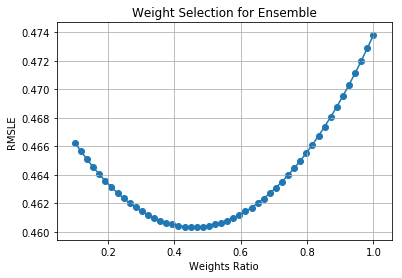

In [24]:
plt.plot(weights, scores)
plt.scatter(weights, scores)
plt.xlabel("Weights Ratio")
plt.ylabel("RMSLE")
plt.title("Weight Selection for Ensemble")
plt.grid()
plt.show()

In [27]:
df_ens = pd.DataFrame({'weights' : weights,'scores':scores})
df_ens.head(5)

,weights,scores
0,0.100000,0.466258
1,0.118367,0.465650
2,0.136735,0.465077
3,0.155102,0.464539
4,0.173469,0.464035


In [44]:
w = df_ens.weights[df_ens.scores == min(df_ens.scores)].values[0]
preds = (w*preds_ridge) + (1-w)*(preds_lgbm)
print('Test RMSLE of Ensemble = ',rmsle_score(np.expm1(y_test) , preds))

Test RMSLE of Ensemble =  0.4603350468883661


### <font color='red'> 9.2 Error Analysis </font>

In [54]:
df_errs = pd.DataFrame({'predicted' : preds,'actual' : np.expm1(y_test)})
df_errs['error'] = df_errs['predicted'] - df_errs['actual']

In [83]:
df_errs['error_slabs'] = pd.cut(df_errs.error, [-20,-15,-10,-5,0,5,10,15,20], include_lowest=True)
df_errs['error_slabs'] = df_errs['error_slabs'].astype(str)
df_errs['error_slabs'][(df_errs['error'] < -20) & (df_errs.error_slabs == 'nan')] = '< -20'
df_errs['error_slabs'][(df_errs['error'] > 20) & (df_errs.error_slabs == 'nan')] = '> 20'

In [103]:
# ref - https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe
# ref - https://stackoverflow.com/questions/43251277/sort-bins-from-pandas-cut

tmp_df = pd.DataFrame(df_errs.groupby('error_slabs').agg('size').reset_index())
tmp_df.columns = ['error_slabs','count']
tmp_df['error_slabs'] = pd.Categorical(tmp_df['error_slabs'], 
                                       ["< -20", "(-20.001, -15.0]", "(-15.0, -10.0]","(-10.0, -5.0]",
                                        "(-5.0, 0.0]","(0.0, 5.0]","(5.0, 10.0]","(10.0, 15.0]",
                                        "(15.0, 20.0]","> 20"])
tmp_df = tmp_df.sort_values(by=['error_slabs'],ascending = True).reset_index(drop = True)
tmp_df['percent'] = round(tmp_df['count']/sum(tmp_df['count']),4)*100
tmp_df

,error_slabs,count,percent
0,< -20,30349,8.19
1,"(-20.001, -15.0]",10540,2.84
2,"(-15.0, -10.0]",18320,4.94
3,"(-10.0, -5.0]",35595,9.60
4,"(-5.0, 0.0]",77720,20.97
5,"(0.0, 5.0]",115671,31.21
6,"(5.0, 10.0]",52284,14.11
7,"(10.0, 15.0]",16492,4.45
8,"(15.0, 20.0]",6128,1.65
9,> 20,7535,2.03


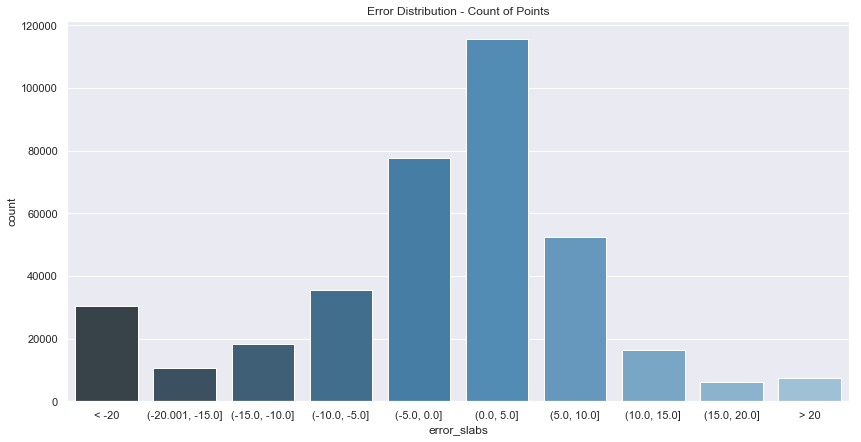

In [100]:
sns.set(rc={'figure.figsize':(14,7)})
sns.barplot(x = 'error_slabs',y = 'count',data = tmp_df,palette="Blues_d")
plt.title('Error Distribution - Count of Points')
plt.show()